# LLE (Locally Linear Embedding)

LLE is one of the many dimensionality reduction methods based on spectral theory. LLE algorithm attempts to create a low dimensional embedding such that points that are nearby in high dimension remain close in low dimensional embedding. The error function is minimized in such a way that the neighborhood around a point does not changes in lower dimension. LLE uses conformal maps to solve the problem. Conformal or biholomorphic maps preserve the local angles between the points. It creates the embedding solely based on neighborhood distances without using global distances. LLE assumes that data lies on a smooth manifold(i.e it does not have holes) and each point and its neighbors lie approximately on a locally linear  patch on the manifold. The latter assumption gives us the freedom to express each point as a weighted sum of its neighbors.   

LLE starts by building a conformal maps of the original dataset and then replicates it in the lower dimensions. 
Suppose , we have $Y_i$ where $i\;\in (1,...,n) \;\text{and}\; Y_i\;\in R^D$. LLE begins by creating a neighborhood matrix. LLE assumes that dataset is large and well-sampled i.e. for every point we have enough to points to create a K-nearest or $\epsilon$-ball neighborhood.   

Once neighborhood matrix is defined, each point is reconstructed as a linear weighted sum of its neighbors. The cost fuction for reconstruction can be formulated as  
$\hspace{7em}\mathcal{E}(W) = \Sigma_{i}(Y_i - \Sigma_{j\in N(i)}^k\; W_{ij}Y_j)^2$  
LLE gets it's name from nature of these reconstructions. Since, only neighbors participate in reconstruction, it is *local* .Reconstruction is acheived by linear coefficients or weights, hence *linear*.  

The weights $W_{ij} $ that contributed to the reconstruction of $X_i$  in higher dimesions should contribute to the reconstruction of the $X_i$ in lower dimension. Based on this idea,  a cost or error function is defined    
$\hspace{7em}\Phi(X) = \Sigma_{i}(X_i - \Sigma_{j}W_{ij}X_j)^2$  where $X$ is the embedding we need to find. 
The difference between the two error functions defined above  is that the weights $W_{ij}$ are fixed in the latter case while in the former  they are variables. The embedding error does not depend on the Y(original dataset) and is a function of geometric information encoded by Weight matrix. With few suitable constraints, error function can be solved using eigenvalue decomposition of $(I-W)^T(I-W)$($I$ is an identity matrix) and a unique solution is obtained. The reconstruction weights of  points $Y_i$ and $Y_j$ are independent from each other. The eigenvalue decomposition is a global operation which process the information provided by all data points. This is the step where geometric information from the weight matrix is incorporated into the global structure of the embedding.


Let's go through each of these steps in details.

#### Neighbor search   
Neighbourhood can be created  through k-nearest neighbor or $\epsilon$-ball neighborhood approach.  
**K-nearest neighbor** - Each point is connected to its K-nearest points. Using this appraoch we will always have K-neighbors for each and every point. Since a point selects exactly K-points and it may be selected by some other point as neighbor which is not in his neighborhood set. This situation generally arises in case of an isolated point which selects faraway points as neighbors, while it's neighbors can select neighborhood set from smaller distance. This produces asymmetric neighborhood matrix.  
**$\epsilon$-ball neighbor** - Each point $Y_i$ selects every point inside the ball with radius $\epsilon$ and centered at $Y_i$ as its neighbors. This approach sometimes leads to points with no neighbors. It is hard to find the right $\epsilon$, since smaller value will give many isolated points and higher value will have many neighbors for each points. This approach is good for approximating geodesic distances.

In [1]:
from sklearn.neighbors import NearestNeighbors 
from sklearn import datasets, neighbors
import numpy as np
# we will implement K-nearest neighbor search
# le's load  fisher iris dataset
iris_ = datasets.load_iris()

iris = iris_.data
def Knbor_Mat(X, K, t = 2.0, dist_metric = "euclidean", algorithm = "ball_tree"):
    
    n,p = X.shape
    
    knn = neighbors.NearestNeighbors(K+1, metric = dist_metric, algorithm=algorithm).fit(X)
    distances, nbors = knn.kneighbors(X)
    
    return(nbors[:,1:])

#### Calculation of reconstruction weights
It is also assumed that dataset is not too noisy, so that we don't have big outliers who distort the weights.  
LLE tries to reconstruct the point $Y_i$ as the weighted average of its neighbors. The reconstruction error is given by  
$\hspace{7em}\mathcal{E}(W) = \Sigma_{i}(Y_i - \Sigma_{j\in N(i)}^k\; W_{ij}Y_j)^2$ where,  
$\hspace{7em}N(i)$ is neighbourhood set of $Y_i$  and  
$\hspace{7em} \Sigma_{j}W_{ij}\; =\; 1.0\;$  
The matrix W has an interesting property it is invariant to rescalings, rotations and translations. The invariance to rotations and rescalings comes from error formulation while $sum_{row}(W)$ = 1 keeps $W_{ij}$ unchanged in case of translations. Using matrix algebra, we get a closed from solution to this problem.   
It is important to note that if the number of neighbors is greater than original dimension *D*, W will not have unique solution and some of the $W_{ij}$ might be zero. This issue can be handled  by adding a regularization term penalizing the large weights.  
Steps to minimize $\mathcal{E}(W)$  
For $i$ in $1:n$;  
$\hspace{2em}$create a matrix $Z$ with all neighbors of $Y_i$  
$\hspace{2em}$subtract $Y_i$ from $Z$  
$\hspace{2em}$create the local covariance matrix $C = ZZ^T$  
$\hspace{2em}$Add a regularized term to avoid C being singular, $C$ $= C + reg*I$  
$\hspace{2em}$solve $CW = 1$ for $W$  
$\hspace{2em}$set $W_{ij} = 0$ if j is not a neighbor of i  
$\hspace{2em}$set $W = W/sum(W)$  


In [2]:
# calculation of reconstruction weights
from scipy import linalg

def get_weights(X, nbors, reg, K):
    
    n,p = X.shape
    
    Weights = np.zeros((n,n))
    
    for i in range(n):
        
        X_bors = X[nbors[i],:] - X[i]
        cov_nbors = np.dot(X_bors, X_bors.T)
        
        #regularization tems
        trace = np.trace(cov_nbors)
        if trace >0 :
            R = reg*trace
        else:
            R = reg
        
        cov_nbors.flat[::K+1] += R
        weights = linalg.solve(cov_nbors, np.ones(K).T, sym_pos=True)

        weights = weights/weights.sum()
        Weights[i, nbors[i]] = weights
        
    return(Weights)

#### calculate the embedded data using the weights
Now, come's the last step of the algorithm i.e. computing the embedded data with the help of reconstruction weights. The error for reconstruction of data in lower dimension is given by  

$\hspace{7em}\Phi(X) = \Sigma_{i}(X_i - \Sigma_{j}W_{ij}X_j)^2$  
Since, $\Sigma_{j}W_{ij} = 1.0$ we can write  
$\hspace{7em}\Phi(X) = \Sigma_{i}(\Sigma_{j}W_{ij}(X_i - X_j)^2) = \Sigma_{i}(\Sigma_{j}(X_i - X_j)W_{ij}(X_i - X_j)^T) $   
$\hspace{9em}= \text{tr}\; X^TMX$    
Now, matrix $M$ = $(I-W)^T(I-W)$.  
We need to add few constraints to make sure we have stable solutions  
$\hspace{7em} \Sigma_i X_i = 0$  
$\hspace{7em} XX^T = I\;\; I$ is identity matrix  
Minimizing $\Phi(X)$ with the constraints leads to unique solution in form of eigenvalue decomposition of M.
We need to select $2^{nd}$ to $(p+1)^{th}$ smallest eigenvectors as the embedded data.


In [3]:
# calculation of the new embedding
from scipy.linalg import eigh

def Y_(Weights,d):
    n,p = Weights.shape
    I = np.eye(n)
    m = (I-Weights)
    M = m.T.dot(m)
    
    eigvals, eigvecs = eigh(M, eigvals=(1, d), overwrite_a=True)
    ind = np.argsort(np.abs(eigvals))
    
    return(eigvecs[:, ind])
    

[354 520 246 134   3 983 186 436 893 921]


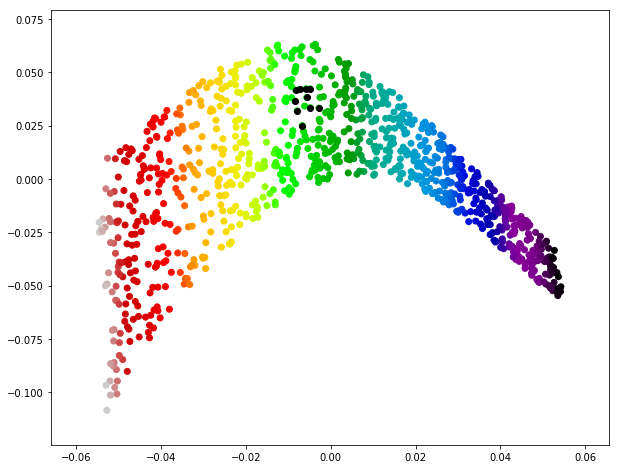

<function __main__.plotter>

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

n_points = 1000
X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)

def LLE_(X, K):
    reg =0.001
    nbors = Knbor_Mat(X,K)
    print(nbors[0])
    Weights = get_weights(X, nbors, reg,K)
    
    Y = Y_(Weights,2)
    return(Y)
test = [354,520, 246,134,3, 983, 186, 436, 893, 921]
def plotter(K):
    fig = plt.figure(figsize=(10,8))
    Y = LLE_(X , K)
    s = Y[test]
    plt.scatter(Y[:,0],Y[:,1],c=color, cmap=plt.cm.spectral)
    plt.scatter(s[:,0],s[:,1], c="black")

interact(plotter, K= widgets.IntSlider(min=10, max=100, value=10, step=10))


### LLE in pyspark
Let's change the LLE code above for pyspark.

In [16]:
#necessary imports

from sklearn import datasets
from pyspark.sql import SQLContext as SQC
from pyspark.mllib.linalg import Vectors as mllibVs, VectorUDT as mllibVUDT
from pyspark.ml.linalg import Vectors as mlVs, VectorUDT as mlVUDT
from pyspark.sql.types import *
from pyspark.mllib.linalg import *
from pyspark.sql.functions import *
from pyspark.ml.feature import StandardScaler
from pyspark.mllib.linalg.distributed import IndexedRowMatrix
import math as m
import numpy as np

sqc = SQC(sc)
iris_tuple = datasets.load_iris()

iris = iris_tuple.data

df = (sqc.createDataFrame(sc.parallelize(iris.tolist()).zipWithIndex().
                              map(lambda x: (x[1], mlVs.dense(x[0]))), ["id", "features"]))    



udf_dist = udf(lambda x, y:  float(x.squared_distance(y)), DoubleType())


df_2 = df
    
df = df.crossJoin(df ).toDF('x_id', 'x_feature', 'y_id', 'y_feature')
df = df.withColumn("sim", udf_dist(df.x_feature, df.y_feature))

df = df.drop("x_feature")

st = struct([name for name in ["y_id", "sim","y_feature"]]).alias("map")
df = df.select("x_id", st)
df  = df.groupby("x_id").agg(collect_list("map").alias("map"))
df = df.join(df_2, df_2.id == df.x_id, "inner").drop("x_id")

# calculate local neighborhood matrix

def get_weights(map_list, k, features, reg):
    

    sorted_map = sorted(map_list, key = lambda x: x[1])[1:(k+1)]
    
    neighbors = np.array([s[2] for s in sorted_map])
    ind = [s[0] for s in sorted_map]
    
    nbors, n_features = neighbors.shape
    
    neighbors_mat = neighbors - features.toArray().reshape(1,n_features)
    
    cov_neighbors = np.dot(neighbors_mat, neighbors_mat.T)
    
    # add regularization term
    trace = np.trace(cov_neighbors)
    if trace > 0:
        R = reg * trace
    else:
        R = reg
    
    cov_neighbors.flat[::nbors + 1] += R
    
    weights = linalg.solve(cov_neighbors, np.ones(k).T, sym_pos=True)
    weights = weights/weights.sum()
    
    full_weights = np.zeros(len(map_list))
    full_weights[ind] = weights
    
    return(Vectors.dense(full_weights))

udf_sort = udf(get_weights, mllibVUDT())

df = df.withColumn("weights", udf_sort("map", lit(10), "features", lit(0.001)))

# udf for creating a row of identity matrix 
def I(ind):
    i = [0]*150
    i[ind]=1.0
    return(mllibVs.dense(i))

# convert dataframe to indexedrowmatrix
weights_irm = IndexedRowMatrix(df.select(["id","weights"]).rdd.map(lambda x:(x[0],  I(x[0])-x[1])))
M = weights_irm.toBlockMatrix().transpose().multiply( weights_irm.toBlockMatrix() )

SVD = M.toIndexedRowMatrix().computeSVD(150, True)

# select the vectors for low dimensional embedding
lle_embbeding = np.fliplr(SVD.V.toArray()[:,-(d+1):-1])


Visualization of **MNIST** dataset

### Advantages and Drawbacks
LLE has got some nice properities. It is simple and provides an elegant closed form solution. The weight matrix is sparse, which makes computation easy. Like isomap, it is hard to find the neighborhood search parameter. Based on the slightly different $K$ or $\epsilon$ LLE can produce completely different results.  

$\hspace{7em}\Sigma_{i}(Y_i - \Sigma_{j\in N(i)}^k\; W_{ij}Y_j)^2$ where,  
$\hspace{7em}N(i)$ is neighbourhood set of $Y_i$  and  
$\hspace{7em} \Sigma_{j}W_{ij}\; =\; 1.0\;$